需要数据集 数据集下载到SVHN\\data\\文件下解压

- 载入需要的包

In [22]:
import os
import glob
from PIL import Image
from cv2 import cv2
import h5py
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
absfile = os.path.abspath(os.path.join(os.getcwd(), ".."))#获取绝对路径

In [30]:
datafile = {
    'data':os.path.join(absfile,'data'),
    'origenal_train':os.path.join(absfile,'data\\train'),
    'origenal_test':os.path.join(absfile,'data\\test'),
    'CRNN_train':os.path.join(absfile,'data\\cr_data\\train'),
    'CRNN_valid':os.path.join(absfile,'data\\cr_data\\valid'),
    'CRNN_test':os.path.join(absfile,'data\\cr_data\\test' )
}
def check_dir(absfile,datafile):
    for i in datafile:
        if os.path.exists(datafile[i]):
            pass
        else:
            os.makedirs(datafile[i])
check_dir(absfile,datafile)
datafile['origenal_digit_struct_train']=os.path.join(absfile,'data\\train\\digitStruct.mat')
datafile['origenal_digit_struct_test']=os.path.join(absfile,'data\\test\\digitStruct.mat')


In [31]:
for i in datafile:
    print(datafile[i])

F:\python\阿里天池训练\学习\零基础入门CV赛事_街景字符编码识别\data
F:\python\阿里天池训练\学习\零基础入门CV赛事_街景字符编码识别\data\train
F:\python\阿里天池训练\学习\零基础入门CV赛事_街景字符编码识别\data\test
F:\python\阿里天池训练\学习\零基础入门CV赛事_街景字符编码识别\data\cr_data\train
F:\python\阿里天池训练\学习\零基础入门CV赛事_街景字符编码识别\data\cr_data\valid
F:\python\阿里天池训练\学习\零基础入门CV赛事_街景字符编码识别\data\cr_data\test
F:\python\阿里天池训练\学习\零基础入门CV赛事_街景字符编码识别\data\train\digitStruct.mat
F:\python\阿里天池训练\学习\零基础入门CV赛事_街景字符编码识别\data\test\digitStruct.mat


- 需要的目录载入

In [32]:
image_train_file = glob.glob(os.path.join(datafile['origenal_train'],'*png'))
image_test_file = glob.glob(os.path.join(datafile['origenal_test'],'*png'))

image_train_file.sort(key = lambda x:int(x.split('\\')[-1][:-4]))
image_test_file.sort(key = lambda x:int(x.split('\\')[-1][:-4]))
image_train_file[0:5]
image_file={'train':image_train_file,'test':image_test_file}
del image_train_file,image_test_file

In [33]:
train_valid_index =[i for i in range(len(image_file['train']))] 
image_train_index,image_valid_index, _,_ = train_test_split(train_valid_index,train_valid_index,test_size=0.1,random_state=42)
image_train_index.sort()
image_valid_index.sort()

In [34]:
image_train_index[0:15]

[0, 1, 2, 3, 4, 5, 8, 9, 10, 11, 12, 13, 14, 15, 16]

- 功能性函数

In [36]:
 def get_attrs(digit_struct_mat_file, index):
    """
    Returns a dictionary which contains keys: label, left, top, width and height, each key has multiple values.
    """
    attrs = {}
    f = digit_struct_mat_file
    item = f['digitStruct']['bbox'][index].item()
    for key in ['label', 'left', 'top', 'width', 'height']:
        attr = f[item][key]
        values = [f[attr[()][i].item()][()][0][0] # 此处[()]是因为h5py的要求 不然有warning
                for i in range(len(attr))] if len(attr) > 1 else [attr[()][0][0]]
        attrs[key] = values
    return attrs
def get_box_loc(path_to_digit_struct_mat_file,index):
    """
        得到图片的边界信息
        path_to_digit_struct_mat_file：原数据集边界信息存储mat目录
        index（int）:索引
    """
    with h5py.File(path_to_digit_struct_mat_file, 'r') as digit_struct_mat_file:
        attrs = get_attrs(digit_struct_mat_file, index)
        length = len(attrs['label'])
        attrs_left, attrs_top, attrs_width, attrs_height = map(lambda x: [int(i) for i in x],
                                                            [attrs['left'], attrs['top'], attrs['width'], attrs['height']])
        min_left, min_top, max_right, max_bottom = (min(attrs_left),
                                                min(attrs_top),
                                                max(map(lambda x, y: x + y, attrs_left, attrs_width)),
                                                max(map(lambda x, y: x + y, attrs_top, attrs_height)))
        # 围绕数字展开边界框
        x_increase = int(((max_right - min_left) *0.3)/2)
        y_increase = int(((max_bottom - min_top) *0.3)/2)
        min_left = min_left - x_increase
        max_right = max_right + x_increase
        min_top = min_top - y_increase
        max_bottom = max_bottom + y_increase
        temp = []
        for i in attrs['label']:
            if (int(i))!=10:
                temp.append(str(int(i)))
            else:
                temp.append('0')
        label = ''.join(temp)
    return  min_left, min_top, max_right, max_bottom,label

In [42]:
def crop_image(image_file,datafile,index,mode = 'train',img_size = (32,32),show=False):
    if mode == 'train':
        path_to_digit_struct_mat_file = datafile['origenal_digit_struct_train']
        write_image_path = datafile['CRNN_train']
    elif mode == 'test' :
        path_to_digit_struct_mat_file = datafile['origenal_digit_struct_test']
        write_image_path = datafile['CRNN_test']
    elif mode == 'valid':
        path_to_digit_struct_mat_file = datafile['origenal_digit_struct_train']
        write_image_path = datafile['CRNN_valid']
    img =cv2.imdecode(np.fromfile(image_file[index],dtype=np.uint8),-1)
    if img is None:
        print('路径错误')
        return False
    min_left, min_top, max_right, max_bottom,label= get_box_loc(path_to_digit_struct_mat_file,index)
    img = img[min_top:max_bottom,min_left:max_right,:]
    if (img is None) or (img.shape[1] == 0) or (img.shape[0]*img.shape[1] <= 450):
        return False
    else:
        img = cv2.resize(img,img_size)
        cv2.imencode('.png', img)[1].tofile(write_image_path+'\\'+str(index)+'_'+label+'_'+str(len(label))+'.png') # 存储成功
        if show:
            plt.axis('off') # 关掉坐标轴为 off
            plt.title(image_path[index].split('\\')[4][:]) # 图像题目
            plt.imshow(img)
    return img,label+'_'+str(len(label))

In [38]:
def deal_all(image_file,datafile,mode ='train'):
    if mode == 'train':
        for i in image_train_index:
            crop_image(image_file['train'],datafile,i,mode='train')
        print('process train data sucessfully')
    elif mode == 'valid':
        for i in image_valid_index_:
            crop_image(image_file['train'],datafile,i,mode='valid')
        print('process valid data sucessfully')
    elif mode =='test':
        for i in range(len(image_file['test'])):
            crop_image(image_file['test'],datafile,i,mode='test')
        print('process test data sucessfully')
    else:
        print('mode commond error')

In [43]:
deal_all(image_file,datafile)
deal_all(image_file,datafile,'valid')
deal_all(image_file,datafile,'test')

KeyboardInterrupt: 

# 显示图像

In [98]:
def show_image(image_path,index):
    img = Image.open(image_path[index]).convert('L')
    # img.show()
    plt.axis('off') # 关掉坐标轴为 off
    plt.title(image_path[index].split('\\')[-1][:]) # 图像题目
    plt.imshow(img)
    return img

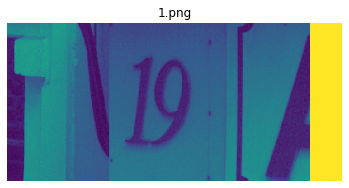

In [99]:
img = show_image(image_path,0)

In [88]:
cnn_img_train_path = os.listdir(save_path[0])
cnn_img_train_path = [save_path[0]+'\\'+i for i in cnn_img_train_path]

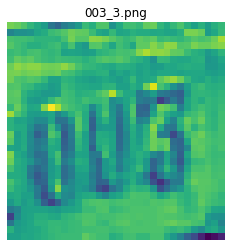

In [91]:
img = show_image(cnn_img_train_path,0)

In [92]:
img.size

(32, 32)